# Causal ML, Uplift Modeling Part 1

## Import Libraries & Data

In [311]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklift.metrics import uplift_at_k,qini_auc_score
from sklift.datasets import fetch_hillstrom # our dataset!
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import optuna
from sklearn.metrics import roc_auc_score, log_loss
from causalml.metrics import auuc_score
import seaborn as sns
import shap
import statsmodels.api as sm

In [312]:
# Load Hillstrom dataset
def load_hillstrom():
    dataset = fetch_hillstrom(target_col='visit')
    df = dataset.data
    # Segment has 3 options, womens email, mens email and no email, so we can create 'treatment' by choosing one of the two treatments here
    df['segment'] = dataset.treatment
    # There are 3 outcomes, visit, conversion and spend, we can choose one of them as our target
    df['visit'] = dataset.target
    print("Are there any null values in this dataframe?\n")
    print(df.isna().sum())
    print("\n\n\n")
    print("What does the dataframe look like? What datatypes are the features?\n")
    print(df.info())
    return df

df = load_hillstrom()

Are there any null values in this dataframe?

recency            0
history_segment    0
history            0
mens               0
womens             0
zip_code           0
newbie             0
channel            0
segment            0
visit              0
dtype: int64




What does the dataframe look like? What datatypes are the features?

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recency          64000 non-null  int64  
 1   history_segment  64000 non-null  object 
 2   history          64000 non-null  float64
 3   mens             64000 non-null  int64  
 4   womens           64000 non-null  int64  
 5   zip_code         64000 non-null  object 
 6   newbie           64000 non-null  int64  
 7   channel          64000 non-null  object 
 8   segment          64000 non-null  object 
 9   visit            64000 non-null  int64

## Explore Data

In [313]:
# The treatment
df['segment'].value_counts()

segment
Womens E-Mail    21387
Mens E-Mail      21307
No E-Mail        21306
Name: count, dtype: int64

In [314]:
# Let's just use men's email first and create a treatment variable to 1/0 the treatment/control
df = df.loc[df['segment'].isin(['Mens E-Mail','No E-Mail'])]
df['treatment'] = df['segment'].map({'Mens E-Mail':1,'No E-Mail':0})
df['treatment'].value_counts(normalize=True)

treatment
1    0.500012
0    0.499988
Name: proportion, dtype: float64

In [315]:
# This dataset has visit, conversion, and revenue as the target variables, we are going to use visit as the target variable
df['target'] = df['visit'].copy()
df['target'].value_counts()

target
0    36457
1     6156
Name: count, dtype: int64

In [316]:
# Customer purchased mens merchandise in the past year
df['mens'].value_counts()

mens
1    23526
0    19087
Name: count, dtype: int64

In [317]:
# Customer purchased womens merchandise in the past year
df['womens'].value_counts()

womens
1    23417
0    19196
Name: count, dtype: int64

In [318]:
# Only a few customers purchased from both mens and womens merch in the past year
df.groupby(['mens','womens']).size()

mens  womens
0     1         19087
1     0         19196
      1          4330
dtype: int64

In [319]:
# segments for TTM spend
df['history_segment'].value_counts()

history_segment
1) $0 - $100        15336
2) $100 - $200       9527
3) $200 - $350       8134
4) $350 - $500       4221
5) $500 - $750       3249
6) $750 - $1,000     1266
7) $1,000 +           880
Name: count, dtype: int64

In [320]:
# Define conditions and corresponding values
conditions = [
    df['history_segment'].isin(['1) $0 - $100', '2) $100 - $200']),
    df['history_segment'].isin(['3) $200 - $350', '4) $350 - $500', '5) $500 - $750'])
]
choices = ['low', 'medium']

# Apply conditions to create the new column
df['history_bins'] = np.select(conditions, choices, default='high')

df['history_bins'].value_counts()


history_bins
low       24863
medium    15604
high       2146
Name: count, dtype: int64

In [321]:
df.groupby('history_bins')['target'].mean()

history_bins
high      0.198509
low       0.121546
medium    0.173545
Name: target, dtype: float64

In [322]:
# Actual TTM spend
df['history'].describe()

count    42613.000000
mean       241.859315
std        256.574723
min         29.990000
25%         64.500000
50%        157.000000
75%        325.210000
max       3345.930000
Name: history, dtype: float64

In [323]:
# Months since last purchase
df['recency'].value_counts()

recency
1     5934
2     5074
10    5022
9     4330
3     3899
4     3406
6     3048
5     2985
7     2720
8     2337
11    2316
12    1542
Name: count, dtype: int64

In [324]:
# New custome in past year
df['newbie'].value_counts()

newbie
1    21381
0    21232
Name: count, dtype: int64

In [325]:
# TTM purchase channels - must be an old dataset given the phone count
df['channel'].value_counts()

channel
Web             18863
Phone           18567
Multichannel     5183
Name: count, dtype: int64

In [326]:
# Classifies urban rural and suburban
df['zip_code'].value_counts()

zip_code
Surburban    19126
Urban        17105
Rural         6382
Name: count, dtype: int64

In [327]:
# Binarize the zip code and channel variables
df = pd.get_dummies(df, columns=['zip_code'], drop_first=True, dtype=int)  # Encode categorical variable
df = pd.get_dummies(df, columns=['channel'], drop_first=True, dtype=int)  # Encode categorical variable
# df = pd.get_dummies(df, columns=['history_segment'], drop_first=True, dtype=int)  # Encode categorical variable
df['recency_bins'] = np.where(df['recency'].between(1,4),'low',np.where(df['recency'].between(5,8),'medium','high'))
df = pd.get_dummies(df, columns=['recency_bins'], drop_first=True, dtype=int)  # Encode categorical variable
df = pd.get_dummies(df, columns=['history_bins'], drop_first=True, dtype=int)  # Encode categorical variable
df = df.drop(columns=['segment','visit','history','recency','history_segment']) # Drop unnecessary features

In [328]:
df = df.rename(columns={'history_segment_2) $100 - $200':'history_segment_100_200',
                        'history_segment_3) $200 - $350':'history_segment_200_350',
                        'history_segment_4) $350 - $500':'history_segment_350_500',
                        'history_segment_5) $500 - $750':'history_segment_500_750',
                        'history_segment_6) $750 - $1,000':'history_segment_750_1000',
                        'history_segment_7) $1,000 +':'history_segment_1000_plus'})

In [329]:
# One grand view of our final dataset! Looks ready for modeling.
df.head()

,mens,womens,newbie,treatment,target,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web,recency_bins_low,recency_bins_medium,history_bins_low,history_bins_medium
1,1,1,1,0,0,0,0,0,1,0,1,0,1
3,1,0,1,1,0,0,0,0,1,0,0,0,1
8,1,1,1,1,0,0,0,1,0,0,0,0,1
13,0,1,0,1,1,0,1,0,1,1,0,1,0
14,0,1,1,0,0,0,0,0,0,1,0,0,1


In [330]:
# It appears everything is just about equal in terms of the treatment group and the control group for feature means, except the target which is ok
df.groupby('treatment').mean()

# Even if it wasn't, we could still run the model using the covariates as features, but would need to adjust for the imbalance in the treatment groups

,mens,womens,newbie,target,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web,recency_bins_low,recency_bins_medium,history_bins_low,history_bins_medium
treatment,,,,,,,,,,,,
0,0.553224,0.547639,0.501971,0.106167,0.451751,0.400920,0.437764,0.439923,0.429879,0.263682,0.584249,0.367033
1,0.550946,0.551415,0.501525,0.182757,0.445910,0.401887,0.433660,0.445394,0.429624,0.256817,0.582672,0.365326


## Feature Engineering to improve model

In [331]:
df.head()

,mens,womens,newbie,treatment,target,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web,recency_bins_low,recency_bins_medium,history_bins_low,history_bins_medium
1,1,1,1,0,0,0,0,0,1,0,1,0,1
3,1,0,1,1,0,0,0,0,1,0,0,0,1
8,1,1,1,1,0,0,0,1,0,0,0,0,1
13,0,1,0,1,1,0,1,0,1,1,0,1,0
14,0,1,1,0,0,0,0,0,0,1,0,0,1


### Difference in visit rates given treatment and given control in different areas of the feature

In [332]:
for i in df.columns.to_list():
    if i not in ['treatment','target']:
        data = df.groupby(['treatment',i]).agg({'target':'mean'}).reset_index()
        diff_on = data.loc[(data['treatment']==1)&(data[i]==1)]['target'].values[0] - data.loc[(data['treatment']==0)&(data[i]==1)]['target'].values[0]
        diff_off = data.loc[(data['treatment']==1)&(data[i]==0)]['target'].values[0] - data.loc[(data['treatment']==0)&(data[i]==0)]['target'].values[0]
        # print(data)
        # print(diff_on)
        # print(diff_off)
        print(f"Feature {i} has a treatment effect of {(diff_on-diff_off)/diff_off*100:.2f}%")

Feature mens has a treatment effect of 15.57%
Feature womens has a treatment effect of 19.38%
Feature newbie has a treatment effect of -3.25%
Feature zip_code_Surburban has a treatment effect of -5.02%
Feature zip_code_Urban has a treatment effect of 6.81%
Feature channel_Phone has a treatment effect of -1.94%
Feature channel_Web has a treatment effect of -2.11%
Feature recency_bins_low has a treatment effect of 20.23%
Feature recency_bins_medium has a treatment effect of -17.27%
Feature history_bins_low has a treatment effect of -21.43%
Feature history_bins_medium has a treatment effect of 27.30%


### Variable Means by treatment and target

In [333]:
for i in df.columns.to_list():
    print(df.groupby(['treatment','target']).agg({i:'mean'}))

                      mens
treatment target          
0         0       0.548047
          1       0.596817
1         0       0.541951
          1       0.591166
                    womens
treatment target          
0         0       0.544423
          1       0.574713
1         0       0.543847
          1       0.585259
                    newbie
treatment target          
0         0       0.517328
          1       0.372679
1         0       0.519095
          1       0.422958
                  treatment
treatment target           
0         0             0.0
          1             0.0
1         0             1.0
          1             1.0
                  target
treatment target        
0         0          0.0
          1          1.0
1         0          0.0
          1          1.0
                  zip_code_Surburban
treatment target                    
0         0                 0.455367
          1                 0.421309
1         0                 0.451042
          1

### Graph out mean target by treatment and feature

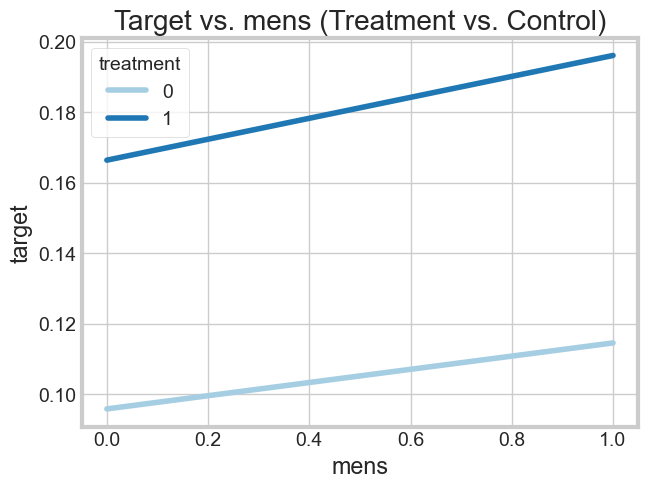

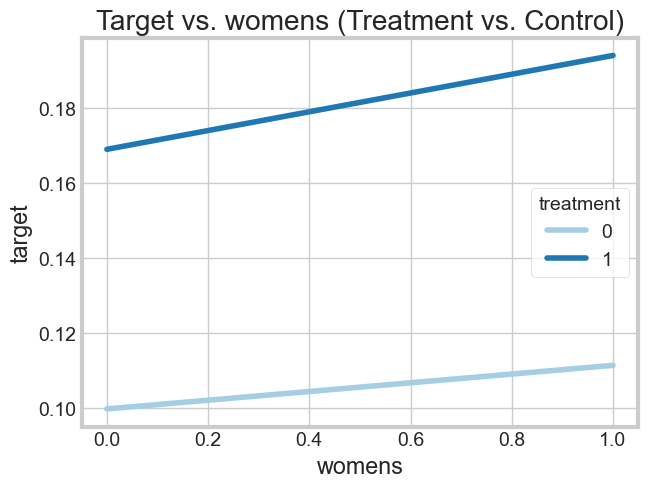

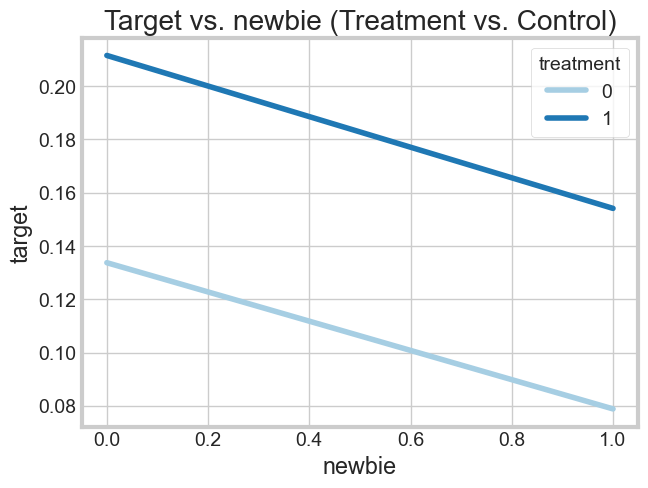

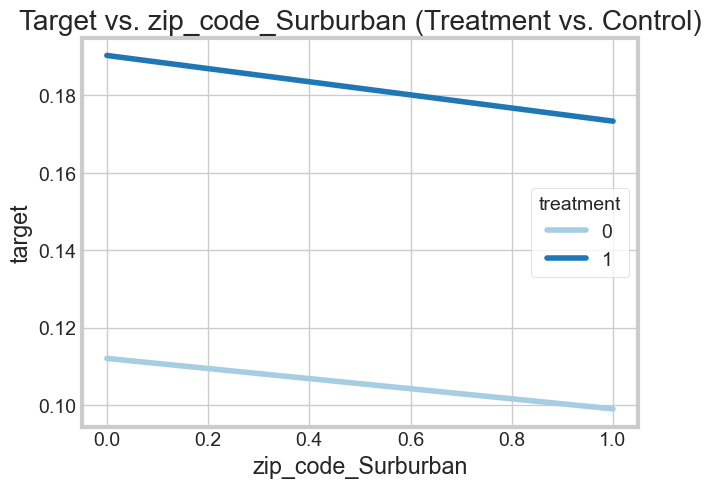

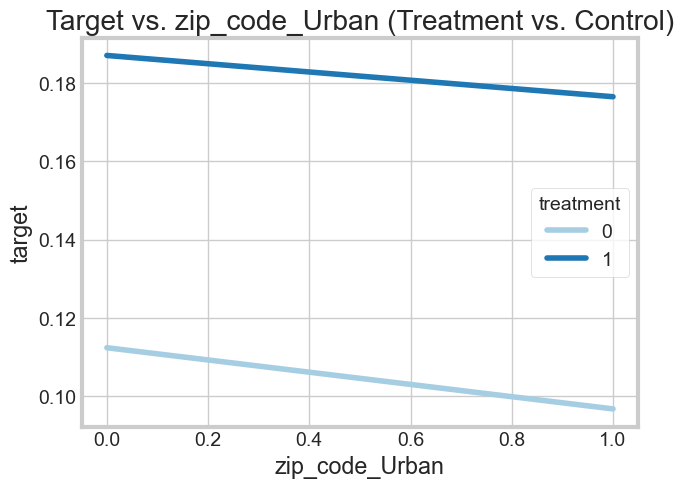

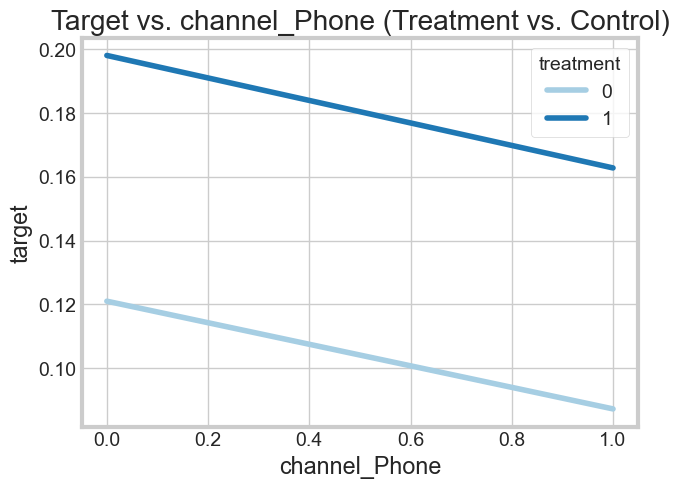

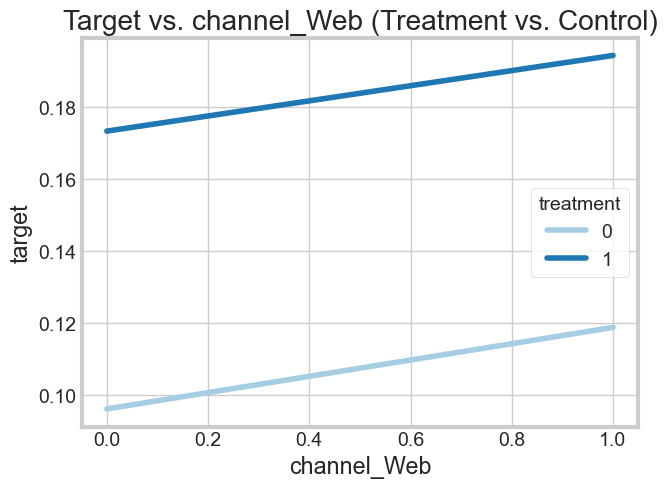

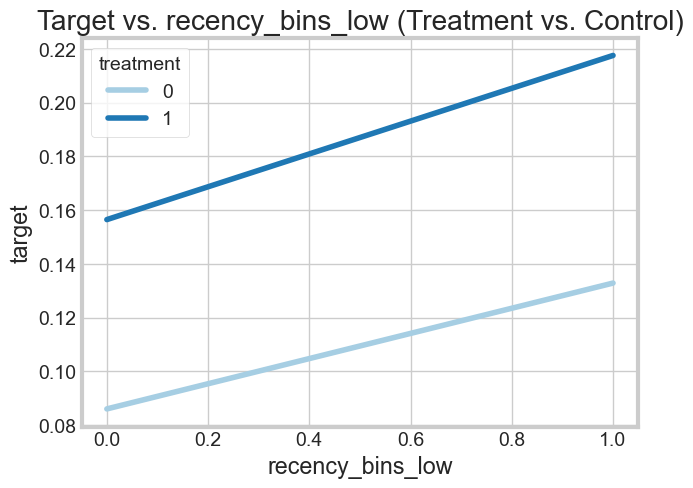

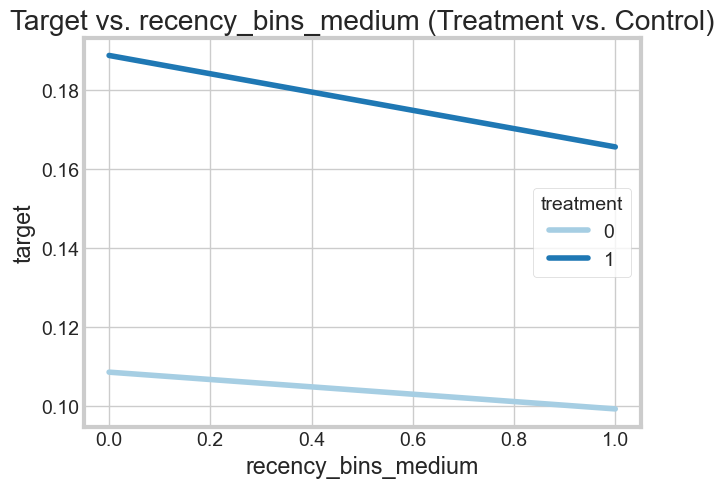

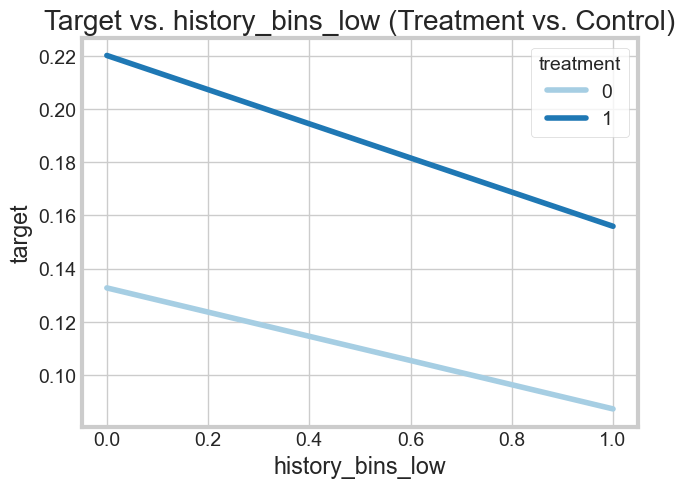

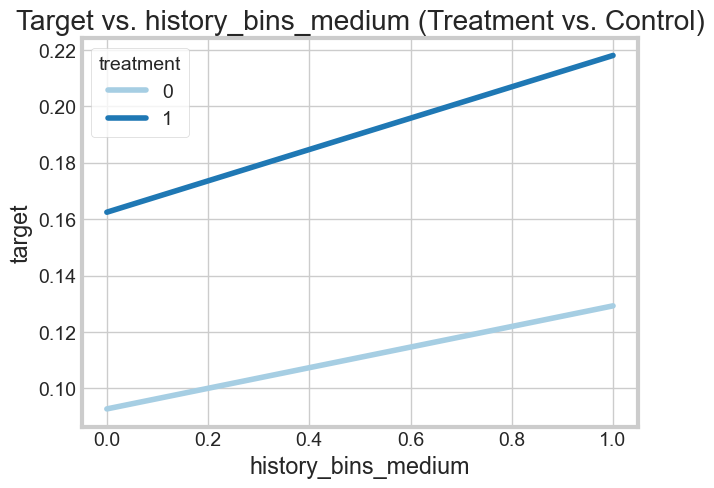

In [334]:
for i in df.columns.to_list():
    if i not in ['treatment','target']:
        # Calculate mean outcomes by recency
        summary = df.groupby(['treatment', i]).agg({'target': 'mean'}).reset_index()

        # Plot outcomes for treatment and control groups
        sns.lineplot(data=summary, x=i, y='target', hue='treatment')
        plt.title(f'Target vs. {i} (Treatment vs. Control)')
        plt.show()

### Create interaction features and test using logistic regression

In [335]:
# Create interaction features

# Hypothesis: Zip code urban will perform better than zip code rural or suburban given the treatment
df['zip_code_Urban_treatment'] = df['zip_code_Urban'] * df['treatment']
df['channel_Phone_treatment'] = df['channel_Phone'] * df['treatment']
df['history_bins_medium_treatment'] = df['history_bins_medium'] * df['treatment']
df['recency_bins_low_treatment'] = df['recency_bins_low'] * df['treatment']

# Final feature list
varlist = [
    'treatment',
    'mens',
    'womens',
    'newbie',
    'recency_bins_low',
    'recency_bins_medium',
    'history_bins_low',
    'history_bins_medium',
    'zip_code_Surburban',
	'zip_code_Urban',
	'channel_Phone',
    'channel_Web',
    # 'history_segment_100_200',
    # 'history_segment_200_350',
    # 'history_segment_350_500',
    # 'history_segment_500_750',
    # 'history_segment_750_1000',
    # 'history_segment_1000_plus',
    
    # 'zip_code_Urban_treatment',
    # 'channel_Phone_treatment',
    # 'history_bins_medium_treatment',
    'recency_bins_low_treatment',
]

df_updated = df[varlist + ['target']]

# run quick regression to see coefficients
sm.Logit(df_updated['target'], sm.add_constant(df_updated[varlist])).fit().summary()

# df_control = df_updated.loc[df_updated['treatment'] == 0]
# df_treatment = df_updated.loc[df_updated['treatment'] == 1]
# X_control = df_control[varlist]
# y_control = df_control['target']
# X_treatment = df_treatment[varlist]
# y_treatment = df_treatment['target']
# sm.Logit(y_control, sm.add_constant(X_control)).fit().summary()
# sm.Logit(y_treatment, sm.add_constant(X_treatment)).fit().summary()

Optimization terminated successfully.
         Current function value: 0.392747
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                42613
Model:                          Logit   Df Residuals:                    42599
Method:                           MLE   Df Model:                           13
Date:                Thu, 26 Dec 2024   Pseudo R-squ.:                 0.04900
Time:                        15:05:48   Log-Likelihood:                -16736.
converged:                       True   LL-Null:                       -17598.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -2.2256      0.106    -20.950      0.000      -2.434      -2.017
treatment                      0.6832      0.041     16.544      0.000       0.602       0.764
mens                           0.6581      0.047     14.131      0.000       0.567       0.749
womens                         0.6291      0.046     13.554      0.000       0.538       0.720
newbie                        -0.5729      0.030    -19.040      0.000      -0.632      -0.514
recency_bins_low               0.5155      0.050     10.339      0.000       0.418       0.613
recency_bins_medium            0.1687      0.040      4.211      0.000       0.090       0.247
history_bins_low              -0.4850      0.068     -7.174      0.000      -0.618      -0.353
history_bins_medium           -0.2789      0.063     -4.419      0.000      -0.403      -0.155
zip_code_Surburban            -0.4006      0.039    -10.249      0.000      -0.477      -0.324
zip_code_Urban                -0.4049      0.040    -10.183      0.000      -0.483      -0.327
channel_Phone                 -0.0866      0.048     -1.808      0.071      -0.181       0.007
channel_Web                    0.1833      0.047      3.895      0.000       0.091       0.276
recency_bins_low_treatment    -0.0714      0.058     -1.236      0.217      -0.185       0.042
==============================================================================================
"""

### Test out features using quick model to see if the score increases

In [121]:
# Quick model test
def build_quick_model():
    # Params from winning model below
    treatment_params = {'n_estimators': 204, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 9, 'max_features': 0.6363649807515354}
    control_params = {'n_estimators': 284, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 0.6613173339747438}

    # Train test split
    X = df.drop(columns=['target','treatment'])
    y = df['target']
    t = df['treatment']
    X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(X, y, t, test_size=0.25)

    # Split datasets into treatment and control models
    X_treatment = X_train[t_train == 1]
    y_treatment = y_train[t_train == 1]
    X_control = X_train[t_train == 0]
    y_control = y_train[t_train == 0]
    X_test_treatment = X_test[t_test == 1]
    y_test_treatment = y_test[t_test == 1]
    X_test_control = X_test[t_test == 0]
    y_test_control = y_test[t_test == 0]

    # Train random forest on treatment and control groups
    t_model = RandomForestClassifier(**treatment_params)
    c_model = RandomForestClassifier(**control_params)
    t_model.fit(X_treatment, y_treatment)
    c_model.fit(X_control, y_control)

    # Make predictions on test sets for treatment and control
    y_pred_treatment = t_model.predict_proba(X_test_treatment)[:, 1]
    y_pred_control = c_model.predict_proba(X_test_control)[:, 1]

    # Calculate model metrics
    print("Treatment Model")
    print(f'ROC AUC: {roc_auc_score(y_test_treatment, y_pred_treatment)}')
    print(f'Log Loss: {log_loss(y_test_treatment, y_pred_treatment)}')
    print("")
    print("Control Model")
    print(f'ROC AUC: {roc_auc_score(y_test_control, y_pred_control)}')
    print(f'Log Loss: {log_loss(y_test_control, y_pred_control)}')
    print("")
    
    # Calculate uplift scores
    uplift_treatment_scores = t_model.predict_proba(X_test)[:, 1]
    uplift_control_scores = c_model.predict_proba(X_test)[:, 1]
    uplift_scores = uplift_treatment_scores - uplift_control_scores
    results_df = pd.DataFrame({
        'y_true': y_test,               # Actual outcomes
        'treatment': t_test,            # Treatment indicators
        'uplift_model': uplift_scores,         # Uplift predictions from Random Forest
    })
    auuc_calc = auuc_score(
        df=results_df,
        outcome_col="y_true",
        treatment_col="treatment",
        treatment_effect_col=None
        )
    print(auuc_calc)

    # Let's try sklift's qini auc score
    qini_score = qini_auc_score(y_test, uplift_scores, t_test)

    comparison_df = pd.DataFrame({
        'Model': ['Two-Model RF'],
        'Qini Score': [qini_score]
    })
    print("\n### Qini Score Comparison ###")
    print(comparison_df)

    return t_model, c_model, X_test

t_model,c_model, X_test = build_quick_model()

### Shapley values assessment

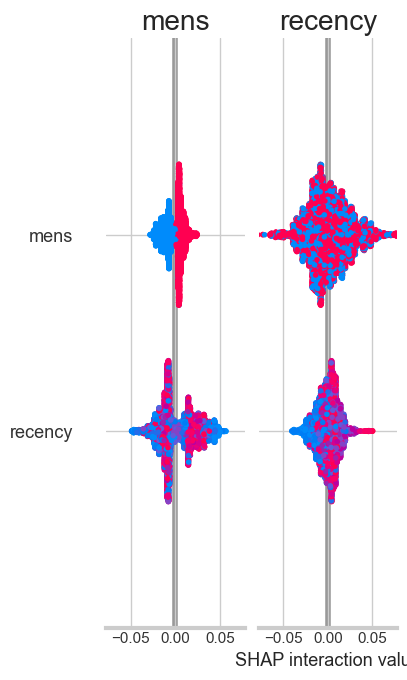

In [120]:
# Train treatment and control models
shap_treatment = shap.TreeExplainer(t_model).shap_values(X_test)
shap_control = shap.TreeExplainer(c_model).shap_values(X_test)

# Compute uplift SHAP values
uplift_shap = np.array(shap_treatment) - np.array(shap_control)

# Visualize feature importance
shap.summary_plot(uplift_shap, X_test)

## Split Train Test Treatment

In [20]:
# Split data into train/test
def split_data(df):
    X = df.drop(columns=['treatment', 'target'])
    y = df['target']
    treatment = df['treatment']
    return train_test_split(X, y, treatment, test_size=0.3)

X_train, X_test, y_train, y_test, t_train, t_test = split_data(df)

## Run Two-Model and Single-Model Approaches

In [21]:
# Model Optimization with Optuna
def optimize_model(trial, X, y, model_type):
    # Set the hyperparameters to optimize and the ranges for xgboost
    if model_type == 'xgboost':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
        }
        model = XGBClassifier(**params, eval_metric='logloss')
        # Even though the eval metric for xgboost is logloss, we are evaluating the hyperparameters on maximizing AUC
    # Set the hyperparameters to optimize the ranges for random forest
    elif model_type == 'random_forest':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 20),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_float('max_features', 0.6, 1.0),
        }
        model = RandomForestClassifier(**params)
    else:
        raise ValueError("Unsupported model type")

    scores = cross_val_score(model, X, y, cv=3, scoring='roc_auc')
    return np.mean(scores)

In [22]:
# Run Optuna for Both Models
def run_optuna(X, y, model_type, model_seg, n_trials=50):
    # Create a study object to maximize the AUC
    study = optuna.create_study(direction='maximize')
    # optimize the study based on the input parameters
    study.optimize(lambda trial: optimize_model(trial, X, y, model_type), n_trials=n_trials)
    print(f"Best parameters for {model_type} for {model_seg}: {study.best_params}")
    return study.best_params

In [23]:
# Train and Evaluate Models
def train_and_evaluate(X_train, X_test, y_train, y_test, params, model_type, model_seg):
    # We'll look at xgboost and random forest, this is to train the final mdoel after optuna works it's magic
    if model_type == 'xgboost':
        model = XGBClassifier(**params,  eval_metric='logloss')
    elif model_type == 'random_forest':
        model = RandomForestClassifier(**params)
    else:
        raise ValueError("Unsupported model type")

    # Fit the model and predict probabilities on the test dataset
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]

    # Grab the AUC & LogLoss metrics for the best model
    auc = roc_auc_score(y_test, y_pred)
    logloss = log_loss(y_test, y_pred)
    print(f"{model_type} AUC for {model_seg}: {auc:.4f}\n{model_type} Log Loss for {model_seg}: {logloss:.4f}")
    return model,y_pred

In [24]:
# Optimize and Train Separate Models for Two-Model Approach
def two_model_approach_with_optuna(X_train, X_test, y_train, y_test, t_train):
    
    # Use function run_optuna to optimize the treatment model for xgboost and random forest adn return the optimal hyperparameters

    # Optimize treatment model for xgboost and random forest
    X_treatment = X_train[t_train == 1]
    y_treatment = y_train[t_train == 1]
    params_treatment_xgboost = run_optuna(X_treatment, y_treatment, 'xgboost','treatment')
    params_treatment_randomforest = run_optuna(X_treatment, y_treatment, 'random_forest','treatment')

    # Optimize control model for xgboost and random forest
    X_control = X_train[t_train == 0]
    y_control = y_train[t_train == 0]
    params_control_xgboost = run_optuna(X_control, y_control, 'xgboost','control')
    params_control_randomforest = run_optuna(X_control, y_control, 'random_forest','control')


    # Optimize single model for xgboost and random forest
    X_single_train = X_train.copy()
    X_single_train['treatment'] = t_train
    X_single_test_1 = X_test.copy()
    X_single_test_1['treatment'] = 1
    X_single_test_0 = X_test.copy()
    X_single_test_0['treatment'] = 0
    params_single_xgboost = run_optuna(X_single_train, y_train, 'xgboost','single')
    params_single_randomforest = run_optuna(X_single_train, y_train, 'random_forest','single')

    # Train final models using function train_and_evaluate
    model_treatment_xgboost,preds_treatment_xgboost = train_and_evaluate(X_treatment, X_test, y_treatment, y_test, params_treatment_xgboost, 'xgboost','treatment')
    model_treatment_randomforest,preds_treatment_randomforest = train_and_evaluate(X_treatment, X_test, y_treatment, y_test, params_treatment_randomforest, 'random_forest','treatment')
    model_control_xgboost,preds_control_xgboost = train_and_evaluate(X_control, X_test, y_control, y_test, params_control_xgboost, 'xgboost','control')
    model_control_randomforest,preds_control_randomforest = train_and_evaluate(X_control, X_test, y_control, y_test, params_control_randomforest, 'random_forest','control')
    model_single_1_xgboost,preds_single_1_xgboost = train_and_evaluate(X_single_train, X_single_test_1, y_train, y_test, params_single_xgboost, 'xgboost','single_1')
    model_single_1_randomforest,preds_single_1_randomforest = train_and_evaluate(X_single_train, X_single_test_1, y_train, y_test, params_single_randomforest, 'random_forest','single_1')
    model_single_0_xgboost,preds_single_0_xgboost = train_and_evaluate(X_single_train, X_single_test_0, y_train, y_test, params_single_xgboost, 'xgboost','single_0')
    model_single_0_randomforest,preds_single_0_randomforest = train_and_evaluate(X_single_train, X_single_test_0, y_train, y_test, params_single_randomforest, 'random_forest','single_0')

    return model_treatment_xgboost, preds_treatment_xgboost, model_treatment_randomforest, preds_treatment_randomforest, model_control_xgboost, preds_control_xgboost, model_control_randomforest, preds_control_randomforest, model_single_1_xgboost, preds_single_1_xgboost, model_single_1_randomforest, preds_single_1_randomforest, model_single_0_xgboost, preds_single_0_xgboost, model_single_0_randomforest, preds_single_0_randomforest

In [25]:
%%time
# Execute the Two-Model Approach with Optuna usng function "two_model_approach_with_optuna"
model_treatment_xgboost, preds_treatment_xgboost, model_treatment_randomforest, preds_treatment_randomforest, model_control_xgboost, preds_control_xgboost, model_control_randomforest, preds_control_randomforest, model_single_1_xgboost, preds_single_1_xgboost, model_single_1_randomforest, preds_single_1_randomforest, model_single_0_xgboost, preds_single_0_xgboost, model_single_0_randomforest, preds_single_0_randomforest = two_model_approach_with_optuna(X_train, X_test, y_train, y_test, t_train)

[I 2024-12-26 09:42:57,659] A new study created in memory with name: no-name-80c9bb8b-8ef7-4135-ac6b-b71b5921b7b4
[I 2024-12-26 09:42:59,746] Trial 0 finished with value: 0.6112898512776405 and parameters: {'n_estimators': 295, 'max_depth': 3, 'learning_rate': 0.039276273021350595, 'subsample': 0.7304468227020526, 'colsample_bytree': 0.7940165913098948, 'gamma': 1.336905815851352}. Best is trial 0 with value: 0.6112898512776405.
[I 2024-12-26 09:43:00,178] Trial 1 finished with value: 0.6123665664542431 and parameters: {'n_estimators': 235, 'max_depth': 4, 'learning_rate': 0.06286663287612552, 'subsample': 0.6874832505095342, 'colsample_bytree': 0.8261643394742544, 'gamma': 3.088458421534524}. Best is trial 1 with value: 0.6123665664542431.
[I 2024-12-26 09:43:00,572] Trial 2 finished with value: 0.6092473290966122 and parameters: {'n_estimators': 108, 'max_depth': 6, 'learning_rate': 0.013112709172199205, 'subsample': 0.8402717631625396, 'colsample_bytree': 0.9563498411532494, 'gamma'

Best parameters for xgboost for treatment: {'n_estimators': 95, 'max_depth': 4, 'learning_rate': 0.2898938470155851, 'subsample': 0.6432302428944832, 'colsample_bytree': 0.7476054722848892, 'gamma': 4.487119982461414}


[I 2024-12-26 09:43:53,777] Trial 0 finished with value: 0.6049236511033342 and parameters: {'n_estimators': 281, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': 0.7016289998437288}. Best is trial 0 with value: 0.6049236511033342.
[I 2024-12-26 09:44:11,562] Trial 1 finished with value: 0.6061893385361196 and parameters: {'n_estimators': 264, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 0.753731708754587}. Best is trial 1 with value: 0.6061893385361196.
[I 2024-12-26 09:44:21,994] Trial 2 finished with value: 0.6056467113392578 and parameters: {'n_estimators': 167, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 0.8714006118455901}. Best is trial 1 with value: 0.6061893385361196.
[I 2024-12-26 09:44:38,145] Trial 3 finished with value: 0.5798157324105441 and parameters: {'n_estimators': 166, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': 0.6318778748966608}. 

Best parameters for random_forest for treatment: {'n_estimators': 204, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 9, 'max_features': 0.6363649807515354}


[I 2024-12-26 09:51:31,142] Trial 0 finished with value: 0.6378092333311098 and parameters: {'n_estimators': 170, 'max_depth': 8, 'learning_rate': 0.022360076550491034, 'subsample': 0.875845082620836, 'colsample_bytree': 0.7059552673961528, 'gamma': 4.440417691707912}. Best is trial 0 with value: 0.6378092333311098.
[I 2024-12-26 09:51:31,339] Trial 1 finished with value: 0.6417372956077161 and parameters: {'n_estimators': 107, 'max_depth': 6, 'learning_rate': 0.06990919133850858, 'subsample': 0.6336194122740769, 'colsample_bytree': 0.7267466242544054, 'gamma': 3.035198101644821}. Best is trial 1 with value: 0.6417372956077161.
[I 2024-12-26 09:51:31,841] Trial 2 finished with value: 0.6046429333745759 and parameters: {'n_estimators': 243, 'max_depth': 10, 'learning_rate': 0.11305692670332979, 'subsample': 0.7529497185593744, 'colsample_bytree': 0.6355281871972689, 'gamma': 0.6359222275276832}. Best is trial 1 with value: 0.6417372956077161.
[I 2024-12-26 09:51:32,058] Trial 3 finished

Best parameters for xgboost for control: {'n_estimators': 99, 'max_depth': 3, 'learning_rate': 0.06123854570589656, 'subsample': 0.7858914583540461, 'colsample_bytree': 0.7044843944103127, 'gamma': 2.6174024200816195}


[I 2024-12-26 09:51:57,546] Trial 0 finished with value: 0.607775552102985 and parameters: {'n_estimators': 269, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 9, 'max_features': 0.7993040603622421}. Best is trial 0 with value: 0.607775552102985.
[I 2024-12-26 09:52:01,617] Trial 1 finished with value: 0.5991643820031612 and parameters: {'n_estimators': 96, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 0.8868352188575952}. Best is trial 0 with value: 0.607775552102985.
[I 2024-12-26 09:52:06,046] Trial 2 finished with value: 0.6071312317217582 and parameters: {'n_estimators': 141, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 0.7609105545463379}. Best is trial 0 with value: 0.607775552102985.
[I 2024-12-26 09:52:15,448] Trial 3 finished with value: 0.6061349928898093 and parameters: {'n_estimators': 300, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_features': 0.671217723321066}. B

Best parameters for random_forest for control: {'n_estimators': 284, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 0.6613173339747438}


[I 2024-12-26 09:55:08,562] Trial 0 finished with value: 0.6516880978955176 and parameters: {'n_estimators': 265, 'max_depth': 5, 'learning_rate': 0.08427258723235384, 'subsample': 0.8962648590879032, 'colsample_bytree': 0.8152058313459913, 'gamma': 1.620367482816421}. Best is trial 0 with value: 0.6516880978955176.
[I 2024-12-26 09:55:08,863] Trial 1 finished with value: 0.6531720907198136 and parameters: {'n_estimators': 107, 'max_depth': 4, 'learning_rate': 0.02525765763476338, 'subsample': 0.8466914044744948, 'colsample_bytree': 0.6962985062263181, 'gamma': 3.094864714344659}. Best is trial 1 with value: 0.6531720907198136.
[I 2024-12-26 09:55:09,701] Trial 2 finished with value: 0.6289671759413692 and parameters: {'n_estimators': 253, 'max_depth': 9, 'learning_rate': 0.06240601911798629, 'subsample': 0.687090824100226, 'colsample_bytree': 0.8152233327500835, 'gamma': 0.9834206259824047}. Best is trial 1 with value: 0.6531720907198136.
[I 2024-12-26 09:55:10,395] Trial 3 finished w

Best parameters for xgboost for single: {'n_estimators': 208, 'max_depth': 3, 'learning_rate': 0.13739010794314319, 'subsample': 0.6000152176538839, 'colsample_bytree': 0.8666018200807054, 'gamma': 4.2755106803110134}


[I 2024-12-26 09:55:37,736] Trial 0 finished with value: 0.6374560954865812 and parameters: {'n_estimators': 238, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 0.8424327265789737}. Best is trial 0 with value: 0.6374560954865812.
[I 2024-12-26 09:55:52,797] Trial 1 finished with value: 0.6129367282614754 and parameters: {'n_estimators': 236, 'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 0.628055480449609}. Best is trial 0 with value: 0.6374560954865812.
[I 2024-12-26 09:56:07,855] Trial 2 finished with value: 0.6235286067954476 and parameters: {'n_estimators': 190, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 9, 'max_features': 0.9529494656382569}. Best is trial 0 with value: 0.6374560954865812.
[I 2024-12-26 09:56:17,817] Trial 3 finished with value: 0.6206271251733463 and parameters: {'n_estimators': 136, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 10, 'max_features': 0.8164418288815833

Best parameters for random_forest for single: {'n_estimators': 274, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 8, 'max_features': 0.6762230192381248}
xgboost AUC for treatment: 0.6217
xgboost Log Loss for treatment: 0.4094
random_forest AUC for treatment: 0.6195
random_forest Log Loss for treatment: 0.4099
xgboost AUC for control: 0.6206
xgboost Log Loss for control: 0.4143
random_forest AUC for control: 0.6170
random_forest Log Loss for control: 0.4161
xgboost AUC for single_1: 0.6237
xgboost Log Loss for single_1: 0.4080
random_forest AUC for single_1: 0.6188
random_forest Log Loss for single_1: 0.4098
xgboost AUC for single_0: 0.6219
xgboost Log Loss for single_0: 0.4134
random_forest AUC for single_0: 0.6161
random_forest Log Loss for single_0: 0.4157
CPU times: total: 35min 54s
Wall time: 20min 50s


In [26]:
# Uplift scores
def create_uplift_scores(preds_treatment_xgboost,
                        preds_control_xgboost,
                        preds_treatment_randomforest,
                        preds_control_randomforest,
                        preds_single_1_xgboost,
                        preds_single_1_randomforest,
                        preds_single_0_xgboost,
                        preds_single_0_randomforest):

    uplift_two_model_rf = preds_treatment_randomforest - preds_control_randomforest

    uplift_two_model_xg = preds_treatment_xgboost - preds_control_xgboost

    uplift_single_model_xg = preds_single_1_xgboost - preds_single_0_xgboost
    
    uplift_single_model_rf = preds_single_1_randomforest - preds_single_0_randomforest
    
    return uplift_two_model_rf, uplift_two_model_xg, uplift_single_model_xg, uplift_single_model_rf

uplift_two_model_rf, uplift_two_model_xg, uplift_single_model_xg, uplift_single_model_rf = create_uplift_scores(preds_treatment_xgboost,
                                                                                                                preds_control_xgboost,
                                                                                                                preds_treatment_randomforest,
                                                                                                                preds_control_randomforest,
                                                                                                                preds_single_1_xgboost,
                                                                                                                preds_single_1_randomforest,
                                                                                                                preds_single_0_xgboost,
                                                                                                                preds_single_0_randomforest
                                                                                                                )

## Compare Two-Model Approaches and Single-Model Approaches

### sklift Qini AUC Score

In [27]:
# Let's try sklift's qini auc score
qini_two_model_rf = qini_auc_score(y_test, uplift_two_model_rf, t_test)
qini_two_model_xg = qini_auc_score(y_test, uplift_two_model_xg, t_test)
qini_single_model_rf = qini_auc_score(y_test, uplift_single_model_rf, t_test)
qini_single_model_xg = qini_auc_score(y_test, uplift_single_model_xg, t_test)

comparison_df = pd.DataFrame({
    'Model': ['Two-Model RF', 'Two-Model XG', 'Single-Model RF', 'Single-Model XG'],
    'Qini Score': [qini_two_model_rf, qini_two_model_xg, qini_single_model_rf, qini_single_model_xg]
})
print("\n### Qini Score Comparison ###")
print(comparison_df)

# We can see initially that the XG, despite outperforming the RF on the individual models by a bit, does not outperform the random forest in the uplift model scenario
# The Two-Model RF beats out the single model RF by a little bit as well. Let's continue on.


### Qini Score Comparison ###
             Model  Qini Score
0     Two-Model RF    0.015537
1     Two-Model XG    0.005175
2  Single-Model RF    0.016189
3  Single-Model XG    0.017795


### Manual Qini Score

In [28]:
# Let's now try a manual calculation of the Qini Score
def calculate_uplift_metrics(df,uplift, n_groups=5):
    """
    Calculate common uplift model evaluation metrics.
    
    Parameters:
    y_true: array-like, actual outcome (visits)
    treatment: array-like, treatment indicator (0/1)
    uplift_scores: array-like, predicted uplift scores
    n_groups: int, number of groups for AUUC calculation
    
    Returns:
    dict with uplift metrics
    """
    # Sort by uplift scores
    df = df.sort_values(by=uplift, ascending=False)
    y_true = df['y_true'].values
    treatment = df['treatment'].values
    
    # Calculate cumulative gains
    n_samples = len(y_true)
    group_size = n_samples // n_groups
    
    gains = []
    for i in range(n_groups):
        start_idx = i * group_size
        end_idx = (i + 1) * group_size if i < n_groups - 1 else n_samples
        
        group_treat = treatment[start_idx:end_idx]
        group_outcome = y_true[start_idx:end_idx]
        
        # Calculate treatment and control response rates
        treat_rate = np.mean(group_outcome[group_treat == 1])
        ctrl_rate = np.mean(group_outcome[group_treat == 0])
        
        # Calculate uplift
        uplift = treat_rate - ctrl_rate
        gains.append(uplift)
    
    # Calculate metrics
    metrics = {
        'AUUC': np.trapz(gains) / len(gains),  # Area Under the Uplift Curve
        'Qini': np.sum(gains),  # Qini coefficient
        'top_group_uplift': gains[0],  # Uplift in highest scored group
        'uplift_by_group': gains
    }
    
    return metrics

In [29]:
# Create a dataframe with test results
results_df = pd.DataFrame({
    'y_true': y_test,               # Actual outcomes
    'treatment': t_test,            # Treatment indicators
    'uplift_tm_rf': uplift_two_model_rf,         # Uplift predictions from Random Forest
    'uplift_tm_xg': uplift_two_model_xg,        # Uplift predictions from XGBoost
    'uplift_sm_rf' : uplift_single_model_rf,
    'uplift_sm_xg' : uplift_single_model_xg
})
results_df.head()

,y_true,treatment,uplift_tm_rf,uplift_tm_xg,uplift_sm_rf,uplift_sm_xg
493,0,0,0.080371,0.078663,0.084573,0.081647
21569,0,1,0.055466,0.049688,0.053182,0.053643
3531,0,0,0.085439,0.077666,0.091903,0.088765
50370,1,1,0.063142,0.073722,0.069832,0.084462
38375,0,1,0.066698,0.110412,0.066020,0.135620


In [30]:
xg_tm_metrics = calculate_uplift_metrics(
   df=results_df,
   uplift='uplift_tm_xg'
   )

rf_tm_metrics = calculate_uplift_metrics(
   df=results_df,
   uplift='uplift_tm_rf'
   )

xg_sm_metrics = calculate_uplift_metrics(
   df=results_df,
   uplift='uplift_sm_xg'
   )

rf_sm_metrics = calculate_uplift_metrics(
   df=results_df,
   uplift='uplift_sm_rf'
   )

In [31]:
print(rf_tm_metrics)
print(xg_tm_metrics)
print(rf_sm_metrics)
print(xg_sm_metrics)
# So here we are seeing the qini scores much higher and more similar.
# The XGBoost models win in this scenario
# For the AUUC, the RF wins for the TM but the XG wins for the SM

{'AUUC': 0.056133910415443224, 'Qini': 0.36728975861969776, 'top_group_uplift': 0.10111677115987461, 'uplift_by_group': [0.10111677115987461, 0.05412037853406218, 0.07670388448190989, 0.06322508251876234, 0.07212364192508874]}
{'AUUC': 0.05693894813771364, 'Qini': 0.3704676898499709, 'top_group_uplift': 0.09408157412922155, 'uplift_by_group': [0.09408157412922155, 0.058874315735331945, 0.055412399542445076, 0.08463507624938849, 0.07746432419358384]}
{'AUUC': 0.05607069090875079, 'Qini': 0.3685965294118244, 'top_group_uplift': 0.09793819167011067, 'uplift_by_group': [0.09793819167011067, 0.06376115893755893, 0.0692264738729207, 0.059122746865203746, 0.07854795806603036]}
{'AUUC': 0.0587033194503954, 'Qini': 0.3690035403144043, 'top_group_uplift': 0.08569916085012938, 'uplift_by_group': [0.08569916085012938, 0.08195659593188727, 0.058608269525267986, 0.07746478873239437, 0.06527472527472528]}


### CausalML AUUC Score

In [32]:
auuc_calc = auuc_score(
        df=results_df,
        outcome_col="y_true",
        treatment_col="treatment",
        treatment_effect_col=None
    )
print(auuc_calc)
# Boy this a bummer, looks like the RF win in this case with the two model RF coming in first, but not much better than random, yikes.

uplift_tm_rf    0.525356
uplift_tm_xg    0.508268
uplift_sm_rf    0.526428
uplift_sm_xg    0.532440
Random          0.514123
dtype: float64


### Decile Chart?

In [33]:
results_df = results_df.sort_values(by='uplift_tm_rf', ascending=False)

In [34]:
results_df['decile_tm_rf'] = pd.qcut(results_df['uplift_tm_rf'], 10, labels=False, duplicates='drop', ) + 1


In [35]:
def calculate_uplift(df):
    treated = df[df['treatment'] == 1]['y_true'].mean()
    control = df[df['treatment'] == 0]['y_true'].mean()
    return treated - control

# Group by decile and calculate observed uplift
decile_uplift = results_df.groupby('decile_tm_rf').apply(calculate_uplift).reset_index(name='observed_uplift_tm_rf')

C:\Users\wallj\AppData\Local\Temp\ipykernel_11352\3131367042.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  decile_uplift = results_df.groupby('decile_tm_rf').apply(calculate_uplift).reset_index(name='observed_uplift_tm_rf')


C:\Users\wallj\AppData\Local\Temp\ipykernel_11352\1261464934.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='decile_tm_rf', y='observed_uplift_tm_rf', data=decile_uplift, palette='Blues_d')


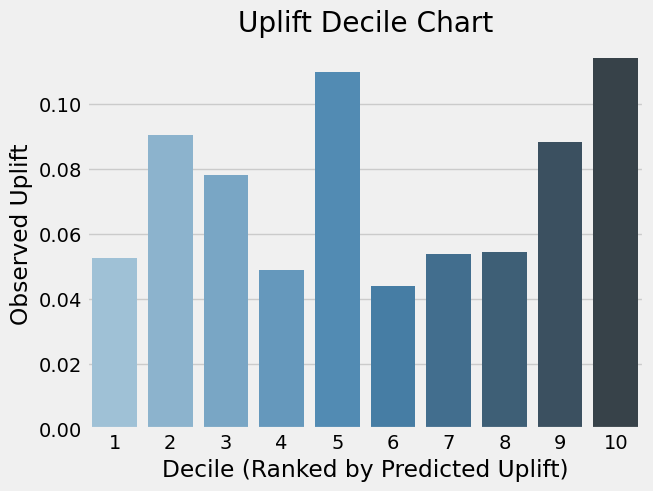

In [36]:
# Plot the observed uplift by decile
sns.barplot(x='decile_tm_rf', y='observed_uplift_tm_rf', data=decile_uplift, palette='Blues_d')
plt.title('Uplift Decile Chart')
plt.xlabel('Decile (Ranked by Predicted Uplift)')
plt.ylabel('Observed Uplift')
plt.show()

This is terrible

### Fake Qini Curve

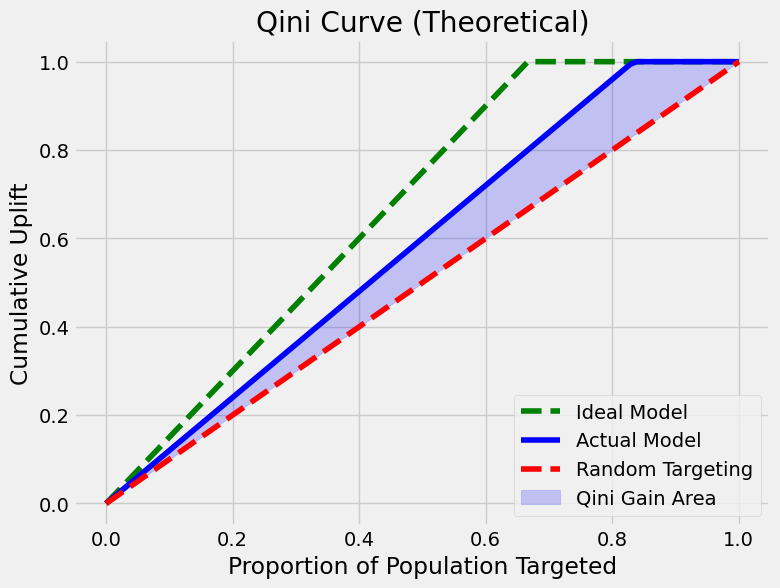

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Create data for a Qini curve
population_targeted = np.linspace(0, 1, 100)  # Proportion of population targeted (X-axis)
random_gain = population_targeted  # Baseline (random targeting)
ideal_gain = np.minimum(population_targeted * 1.5, 1.0)  # Ideal model (optimistic upper bound)
model_gain = np.minimum(population_targeted * 1.2, 1.0)  # Typical uplift model

# Plot the Qini curve
plt.figure(figsize=(8, 6))
plt.plot(population_targeted, ideal_gain, label="Ideal Model", linestyle="--", color="green")
plt.plot(population_targeted, model_gain, label="Actual Model", color="blue")
plt.plot(population_targeted, random_gain, label="Random Targeting", linestyle="--", color="red")
plt.fill_between(population_targeted, random_gain, model_gain, color="blue", alpha=0.2, label="Qini Gain Area")

# Customize plot
plt.title("Qini Curve (Theoretical)")
plt.xlabel("Proportion of Population Targeted")
plt.ylabel("Cumulative Uplift")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


### Qini Curve from Kaggle

In [38]:
results_df['target_class'] = 0  # Initialize column
results_df.loc[(results_df['treatment'] == 0) & (results_df['y_true'] == 1), 'target_class'] = 1
results_df.loc[(results_df['treatment'] == 1) & (results_df['y_true'] == 0), 'target_class'] = 2
results_df.loc[(results_df['treatment'] == 1) & (results_df['y_true'] == 1), 'target_class'] = 3

In [39]:
results_df.head()

,y_true,treatment,uplift_tm_rf,uplift_tm_xg,uplift_sm_rf,uplift_sm_xg,decile_tm_rf,target_class
53911,0,1,0.205605,0.248598,0.182196,0.162354,10,2
29341,1,1,0.203055,0.248598,0.186907,0.162354,10,3
49746,0,1,0.199268,0.241700,0.182045,0.175620,10,2
52156,1,1,0.198872,0.241700,0.182018,0.181726,10,3
17847,0,0,0.198581,0.297748,0.175863,0.175620,10,0


In [40]:
def qini_rank(uplift: pd.DataFrame, uplift_score: str) -> pd.DataFrame:
    """Rank the data by the uplift score for a specific model."""
    ranked = uplift[['target_class', uplift_score]].copy()
    ranked.rename(columns={uplift_score: 'uplift_score'}, inplace=True)

    # Add proportion
    ranked['n'] = ranked['uplift_score'].rank(pct=True, ascending=False)

    # Data Ranking
    ranked = ranked.sort_values(by='n').reset_index(drop=True)
    return ranked

In [41]:
def qini_eval(ranked: pd.DataFrame) -> pd.DataFrame:
    """Evaluate the uplift value with the QINI criterion."""
    uplift_model = ranked.copy()
    random_model = ranked.copy()

    # Calculate cumulative gains for treatment and control groups
    C = sum(ranked['target_class'] <= 1)  # Total control group
    T = sum(ranked['target_class'] >= 2)  # Total treatment group
    ranked['cr'] = 0
    ranked['tr'] = 0
    ranked.loc[ranked.target_class == 1, 'cr'] = 1
    ranked.loc[ranked.target_class == 3, 'tr'] = 1
    ranked['cr/c'] = ranked['cr'].cumsum() / C
    ranked['tr/t'] = ranked['tr'].cumsum() / T

    # Calculate uplift for the model and random targeting
    uplift_model['uplift'] = round(ranked['tr/t'] - ranked['cr/c'], 5)
    random_model['uplift'] = round(ranked['n'] * uplift_model['uplift'].iloc[-1], 5)

    # Add q0 for initial point
    q0 = pd.DataFrame({'n': [0], 'uplift': [0], 'target_class': [None]})
    uplift_model = pd.concat([q0, uplift_model]).reset_index(drop=True)
    random_model = pd.concat([q0, random_model]).reset_index(drop=True)

    # Add model names and combine
    uplift_model['model'] = 'Uplift model'
    random_model['model'] = 'Random model'
    merged = pd.concat([uplift_model, random_model]).sort_values(by='n').reset_index(drop=True)
    return merged


In [42]:
def qini_plot(merged: pd.DataFrame):
    """Plot QINI curves for multiple models."""
    sns.set_style('whitegrid')

    # Plot the data
    ax = sns.lineplot(
        x='n', y='uplift', hue='model', data=merged, style='model', palette='Set2'
    )

    # Customize plot settings
    plt.xlabel('Proportion Targeted', fontsize=15)
    plt.ylabel('Uplift', fontsize=15)
    plt.title('Qini Curves for Multiple Models', fontsize=16)
    plt.legend(fontsize=12)
    ax.tick_params(labelsize=12)
    plt.grid(True)
    plt.show()
    return ax

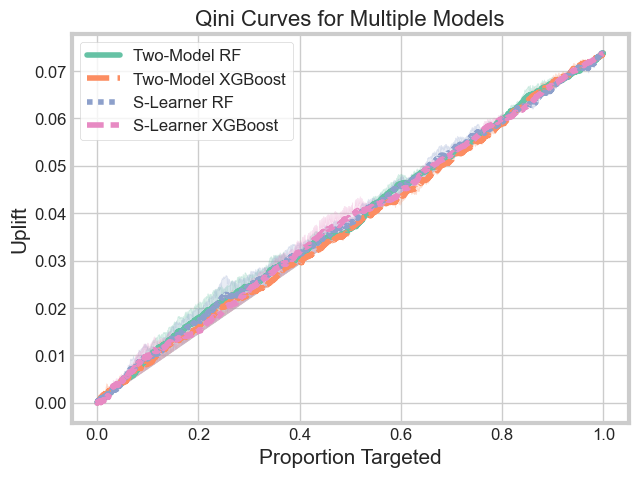

<Axes: title={'center': 'Qini Curves for Multiple Models'}, xlabel='Proportion Targeted', ylabel='Uplift'>

In [43]:
# Combine QINI results for all models
merged_results = pd.DataFrame()

# List of uplift columns for different models
uplift_columns = ['uplift_tm_rf', 'uplift_tm_xg', 'uplift_sm_rf', 'uplift_sm_xg']
model_names = ['Two-Model RF', 'Two-Model XGBoost', 'S-Learner RF', 'S-Learner XGBoost']

for uplift_score, model_name in zip(uplift_columns, model_names):
    ranked = qini_rank(results_df, uplift_score)
    merged = qini_eval(ranked)
    merged['model'] = model_name  # Add model name for identification
    merged_results = pd.concat([merged_results, merged], ignore_index=True)

# Plot all QINI curves
qini_plot(merged_results)